In [2]:
! pip install rasterio

  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 64.9 MB/s eta 0:00:00a 0:00:01
Using cached affine-2.4.0-py3-none-any.whl (15 kB)


In [19]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
from rasterio.windows import from_bounds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import Transformer

# DEM file
dem_file = 'USGS1m_topo/viz.USGS1m_color-relief.tif'

# Load ASCII DEM
asc_file = 'USGS1m_topo/output_USGS1m.asc'

In [17]:


# Station data
stations = pd.DataFrame({
    'stnm': ['002','001','003','004','005','006'],
    'lat': [40.794796, 40.794836, 40.794740, 40.794670, 40.794660, 40.794660],
    'lon': [-111.779490, -111.779309, -111.779110, -111.778810, -111.778630, -111.778400],
    'stnm_renamed': ['N051','N037','N018','S009','S024','S043']
})


# Define bounding box
Xmin, Ymin = -111.785, 40.792
Xmax, Ymax = -111.772, 40.798

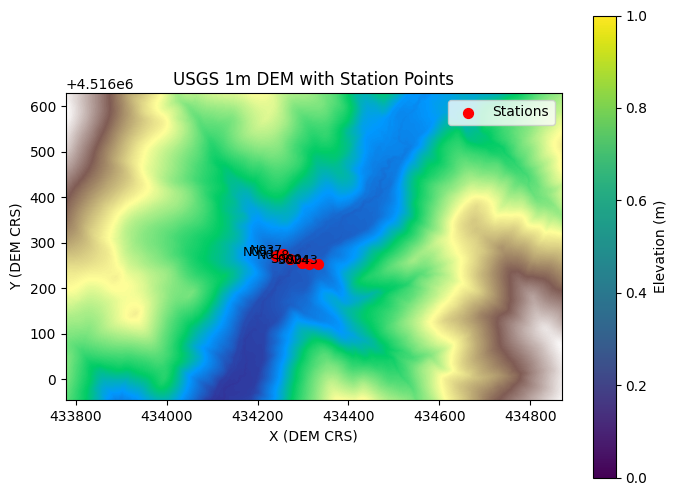

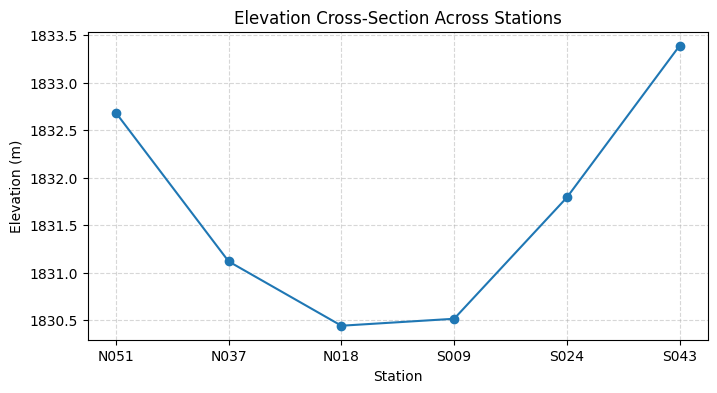

  stnm_renamed     dem_elev
0         N051  1832.683105
1         N037  1831.119385
2         N018  1830.443115
3         S009  1830.516235
4         S024  1831.792480
5         S043  1833.389404


In [26]:
with open(asc_file) as f:
    header = {}
    for i in range(6):
        line = f.readline()
        key, value = line.strip().split()
        header[key] = float(value)
    dem = np.loadtxt(f)

ncols = int(header['ncols'])
nrows = int(header['nrows'])
xllcorner = header['xllcorner']
yllcorner = header['yllcorner']
cellsize = header['cellsize']
nodata = header.get('NODATA_value', -9999)

# Compute DEM coordinates
x = xllcorner + np.arange(ncols) * cellsize
y = yllcorner + np.arange(nrows) * cellsize

# --- Coordinate transformation ---
dem_crs_epsg = 'EPSG:32612'  # Replace with actual DEM CRS
wgs84_epsg = 'EPSG:4326'
transformer = Transformer.from_crs(wgs84_epsg, dem_crs_epsg, always_xy=True)
stations['x'], stations['y'] = transformer.transform(stations['lon'].tolist(), stations['lat'].tolist())

# Map station x/y to nearest row/col, flipping y-axis
station_elev = []
for xi, yi in zip(stations['x'], stations['y']):
    col = int((xi - xllcorner) / cellsize)
    row = nrows - 1 - int((yi - yllcorner) / cellsize)  # flip row
    # Clip indices to DEM size
    col = np.clip(col, 0, ncols-1)
    row = np.clip(row, 0, nrows-1)
    station_elev.append(dem[row, col])

stations['dem_elev'] = station_elev

# Plot DEM map with correct orientation
plt.figure(figsize=(8,6))
plt.imshow(dem, cmap='terrain',
           extent=[xllcorner, xllcorner + ncols*cellsize, yllcorner, yllcorner + nrows*cellsize],
           origin='upper')  # origin upper matches ASCII convention
plt.scatter(stations['x'], stations['y'], color='red', s=50, label='Stations')
for idx, row in stations.iterrows():
    plt.text(row['x'], row['y'], row['stnm_renamed'], fontsize=9, ha='right')
plt.colorbar(label='Elevation (m)')
plt.xlabel('X (DEM CRS)')
plt.ylabel('Y (DEM CRS)')
plt.title('USGS 1m DEM with Station Points')
plt.legend()
plt.show()

# Elevation cross-section
plt.figure(figsize=(8,4))
plt.plot(stations['stnm_renamed'], stations['dem_elev'], marker='o', linestyle='-')
plt.xlabel('Station')
plt.ylabel('Elevation (m)')
plt.title('Elevation Cross-Section Across Stations')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(stations[['stnm_renamed','dem_elev']])

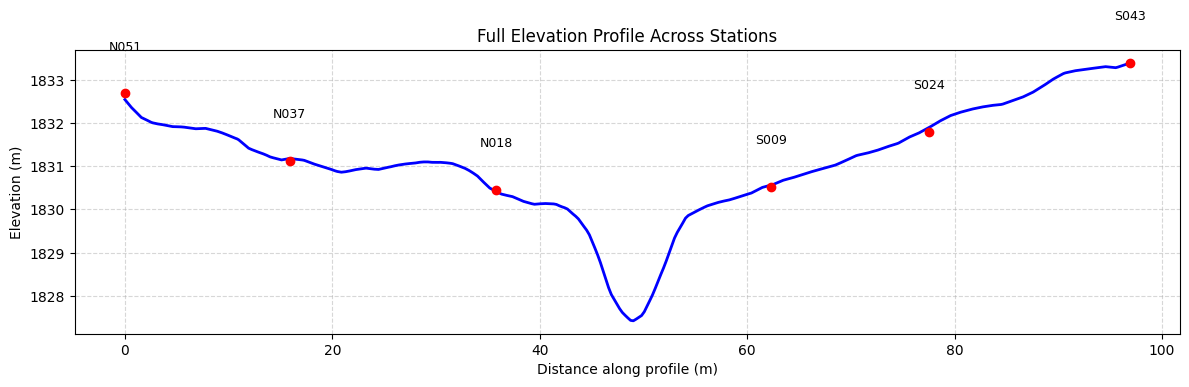

   Distance_m  Elevation_m
0    0.000000  1832.539308
1    0.159028  1832.492459
2    0.318056  1832.444374
3    0.477085  1832.395051
4    0.636113  1832.354790


In [31]:

from scipy.interpolate import RegularGridInterpolator

# Prepare DEM interpolator
# dem_y and dem_x must match DEM orientation (top-left origin)
dem_y = yllcorner + (nrows - 1 - np.arange(nrows)) * cellsize
dem_x = xllcorner + np.arange(ncols) * cellsize
interp = RegularGridInterpolator((dem_y, dem_x), dem)

# Create a line through all stations (projected coordinates)
line_points = []
n_points_between = 100  # points between each station for smooth profile
for i in range(len(stations)-1):
    x_start, y_start = stations['x'].iloc[i], stations['y'].iloc[i]
    x_end, y_end = stations['x'].iloc[i+1], stations['y'].iloc[i+1]
    xs = np.linspace(x_start, x_end, n_points_between, endpoint=False)
    ys = np.linspace(y_start, y_end, n_points_between, endpoint=False)
    for x_, y_ in zip(xs, ys):
        line_points.append([y_, x_])  # note: interpolator expects (y,x)

# Add last station point
line_points.append([stations['y'].iloc[-1], stations['x'].iloc[-1]])

line_points = np.array(line_points)

# Sample DEM along the line
profile_elev = interp(line_points)

# Compute cumulative distance along the line
dx = np.diff(line_points[:,1])
dy = np.diff(line_points[:,0])
distances = np.zeros(len(line_points))
distances[1:] = np.cumsum(np.sqrt(dx**2 + dy**2))

# Plot full elevation profile
plt.figure(figsize=(12,4))
plt.plot(distances, profile_elev, color='blue', linewidth=2)
# Mark station points
station_distances = [distances[0]]
for i in range(1, len(stations)):
    station_distances.append(distances[i*n_points_between])
plt.scatter(station_distances, stations['dem_elev'], color='red', zorder=5)
for d, elev, stn in zip(station_distances, stations['dem_elev'], stations['stnm_renamed']):
    plt.text(d, elev + 1, stn, fontsize=9, ha='center')
plt.xlabel('Distance along profile (m)')
plt.ylabel('Elevation (m)')
plt.title('Full Elevation Profile Across Stations')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Optional: create a DataFrame of all sampled points
profile_df = pd.DataFrame({'Distance_m': distances, 'Elevation_m': profile_elev})
print(profile_df.head())


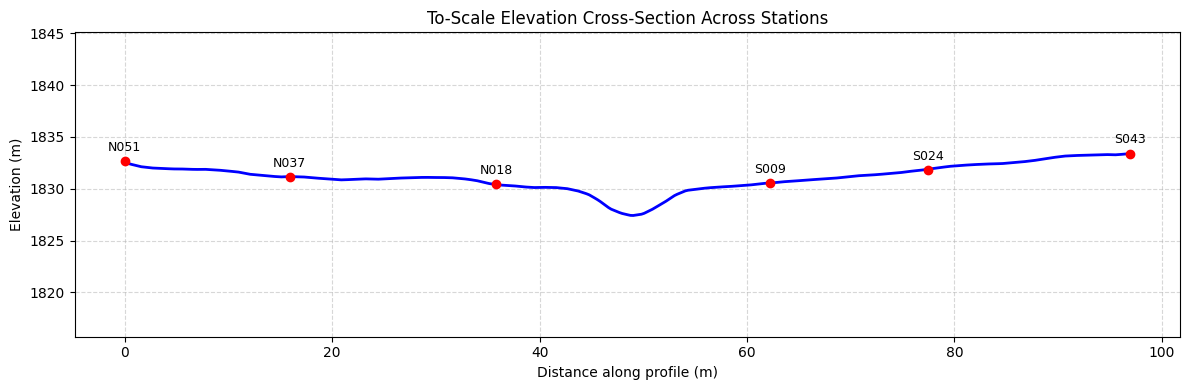

In [32]:

from scipy.interpolate import RegularGridInterpolator

# --- Prepare DEM interpolator ---
dem_y = yllcorner + (nrows - 1 - np.arange(nrows)) * cellsize
dem_x = xllcorner + np.arange(ncols) * cellsize
interp = RegularGridInterpolator((dem_y, dem_x), dem)

# --- Sample line along stations ---
line_points = []
n_points_between = 100  # number of points between stations
for i in range(len(stations)-1):
    x_start, y_start = stations['x'].iloc[i], stations['y'].iloc[i]
    x_end, y_end = stations['x'].iloc[i+1], stations['y'].iloc[i+1]
    xs = np.linspace(x_start, x_end, n_points_between, endpoint=False)
    ys = np.linspace(y_start, y_end, n_points_between, endpoint=False)
    for x_, y_ in zip(xs, ys):
        line_points.append([y_, x_])  # (y,x) for interpolator

# Add last station point
line_points.append([stations['y'].iloc[-1], stations['x'].iloc[-1]])
line_points = np.array(line_points)

# Sample DEM elevations
profile_elev = interp(line_points)

# Compute cumulative distance along the profile
dx = np.diff(line_points[:,1])
dy = np.diff(line_points[:,0])
distances = np.zeros(len(line_points))
distances[1:] = np.cumsum(np.sqrt(dx**2 + dy**2))

# --- To-scale plot ---
plt.figure(figsize=(12,4))
plt.plot(distances, profile_elev, color='blue', linewidth=2)

# Mark station points
station_distances = [distances[0]]
for i in range(1, len(stations)):
    station_distances.append(distances[i*n_points_between])
plt.scatter(station_distances, stations['dem_elev'], color='red', zorder=5)
for d, elev, stn in zip(station_distances, stations['dem_elev'], stations['stnm_renamed']):
    plt.text(d, elev + 1, stn, fontsize=9, ha='center')

plt.xlabel('Distance along profile (m)')
plt.ylabel('Elevation (m)')
plt.title('To-Scale Elevation Cross-Section Across Stations')
plt.grid(True, linestyle='--', alpha=0.5)

# Set equal scaling for x and y axes for to-scale view
plt.axis('equal')
plt.tight_layout()
plt.show()
